In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
from pathlib import Path
from datetime import datetime
import warnings
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (14, 7)})

In [2]:
# Helper function
def display_all(df):
    with pd.option_context('display.max_rows',1000, 'display.max_columns', 1000):
        display(df)

## Load, Assess and Prep Data

In [3]:
# Load data
data = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv", 
                   delimiter='\t',
                   low_memory=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
display_all(data.head())

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0

In [5]:
# Number of unique elements per column
data.nunique()

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

In [6]:
#Converting column names to lower case
data.columns = data.columns.str.lower()
# Doing the same for string in individual columns
str_cols = ['education', 'marital_status', 'dt_customer']
data[str_cols] = data[str_cols].apply(lambda x: x.str.lower())
data.head()

id  year_birth   education marital_status   income  kidhome  teenhome  \
0  5524        1957  graduation         single  58138.0        0         0   
1  2174        1954  graduation         single  46344.0        1         1   
2  4141        1965  graduation       together  71613.0        0         0   
3  6182        1984  graduation       together  26646.0        1         0   
4  5324        1981         phd        married  58293.0        1         0   

  dt_customer  recency  mntwines  ...  numwebvisitsmonth  acceptedcmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   acceptedcmp4  acceptedcmp5  acceptedcmp1  acceptedcmp2  complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   z_costcontact  z_revenue  response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [7]:
display_all(data.describe(include='all').round(1))

id  year_birth   education marital_status    income  kidhome  \
count    2240.0      2240.0        2240           2240    2216.0   2240.0   
unique      NaN         NaN           5              8       NaN      NaN   
top         NaN         NaN  graduation        married       NaN      NaN   
freq        NaN         NaN        1127            864       NaN      NaN   
mean     5592.2      1968.8         NaN            NaN   52247.3      0.4   
std      3246.7        12.0         NaN            NaN   25173.1      0.5   
min         0.0      1893.0         NaN            NaN    1730.0      0.0   
25%      2828.2      1959.0         NaN            NaN   35303.0      0.0   
50%      5458.5      1970.0         NaN            NaN   51381.5      0.0   
75%      8427.8      1977.0         NaN            NaN   68522.0      1.0   
max     11191.0      1996.0         NaN            NaN  666666.0      2.0   

        teenhome dt_customer  recency  mntwines  mntfruits  mntmeatproducts  \
count     2240.0        2240   2240.0    2240.0     2240.0           2240.0   
unique       NaN         663      NaN       NaN        NaN              NaN   
top          NaN  31-08-2012      NaN       NaN        NaN              NaN   
freq         NaN          12      NaN       NaN        NaN              NaN   
mean         0.5         NaN     49.1     303.9       26.3            167.0   
std          0.5         NaN     29.0     336.6       39.8            225.7   
min          0.0         NaN      0.0       0.0        0.0              0.0   
25%          0.0         NaN     24.0      23.8        1.0             16.0   
50%          0.0         NaN     49.0     173.5        8.0             67.0   
75%          1.0         NaN     74.0     504.2       33.0            232.0   
max          2.0         NaN     99.0    1493.0      199.0           1725.0   

        mntfishproducts  mntsweetproducts  mntgoldprods  numdealspurchases  \
count            2240.0            2240.0        2240.0             2240.0   
unique              NaN               NaN           NaN                NaN   
top                 NaN               NaN           NaN                NaN   
freq                NaN               NaN           NaN                NaN   
mean               37.5              27.1          44.0                2.3   
std                54.6              41.3          52.2                1.9   
min                 0.0               0.0           0.0                0.0   
25%                 3.0               1.0           9.0                1.0   
50%                12.0               8.0          24.0                2.0   
75%                50.0              33.0          56.0                3.0   
max               259.0             263.0         362.0               15.0   

        numwebpurchases  numcatalogpurchases  numstorepurchases  \
count            2240.0               2240.0             2240.0   
unique              NaN                  NaN                NaN   
top                 NaN                  NaN                NaN   
freq                NaN                  NaN                NaN   
mean                4.1                  2.7                5.8   
std                 2.8                  2.9                3.3   
min                 0.0                  0.0                0.0   
25%                 2.0                  0.0                3.0   
50%                 4.0                  2.0                5.0   
75%                 6.0                  4.0                8.0   
max                27.0                 28.0               13.0   

        numwebvisitsmonth  acceptedcmp3  acceptedcmp4  acceptedcmp5  \
count              2240.0        2240.0        2240.0        2240.0   
unique                NaN           NaN           NaN           NaN   
top                   NaN           NaN           NaN           NaN   
freq                  NaN           NaN           NaN           NaN   
mean                  5.3           0.1   

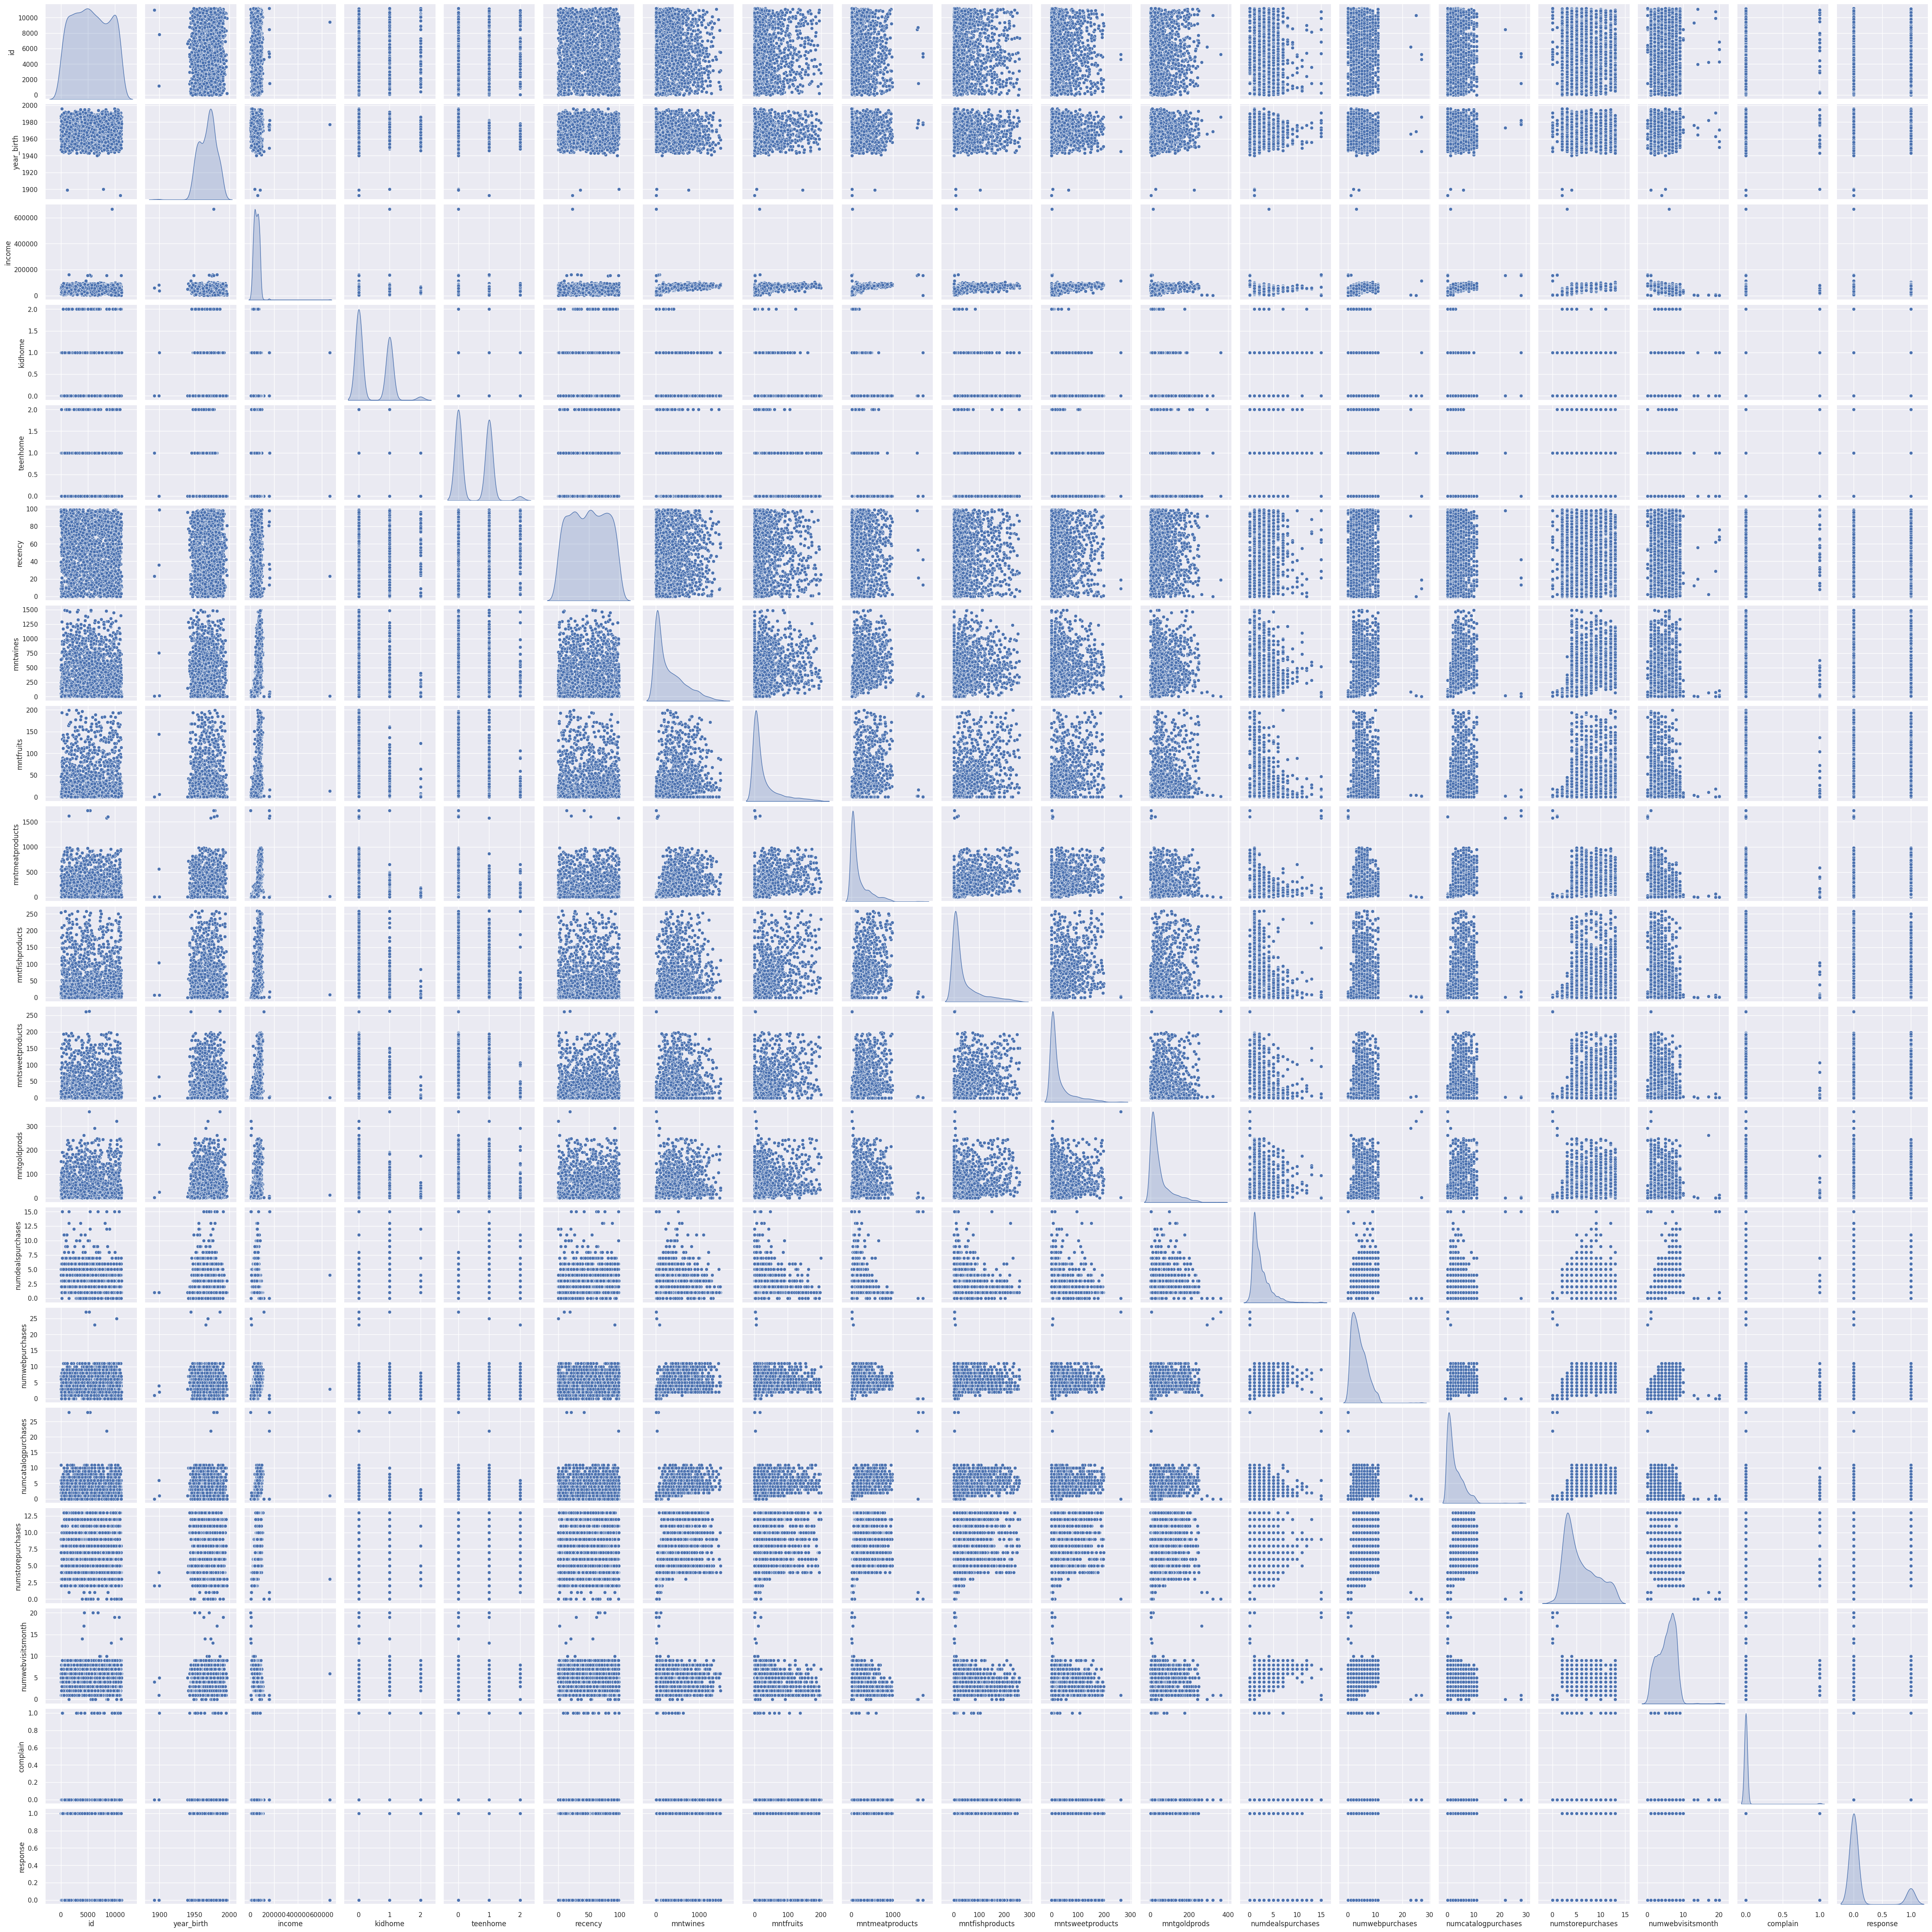

In [8]:
# Filter cols
cols = [col for col in data.columns if 'accept' not in col and 'z' not in col]
# Distributions 
sns.pairplot(data[cols], diag_kind='kde');

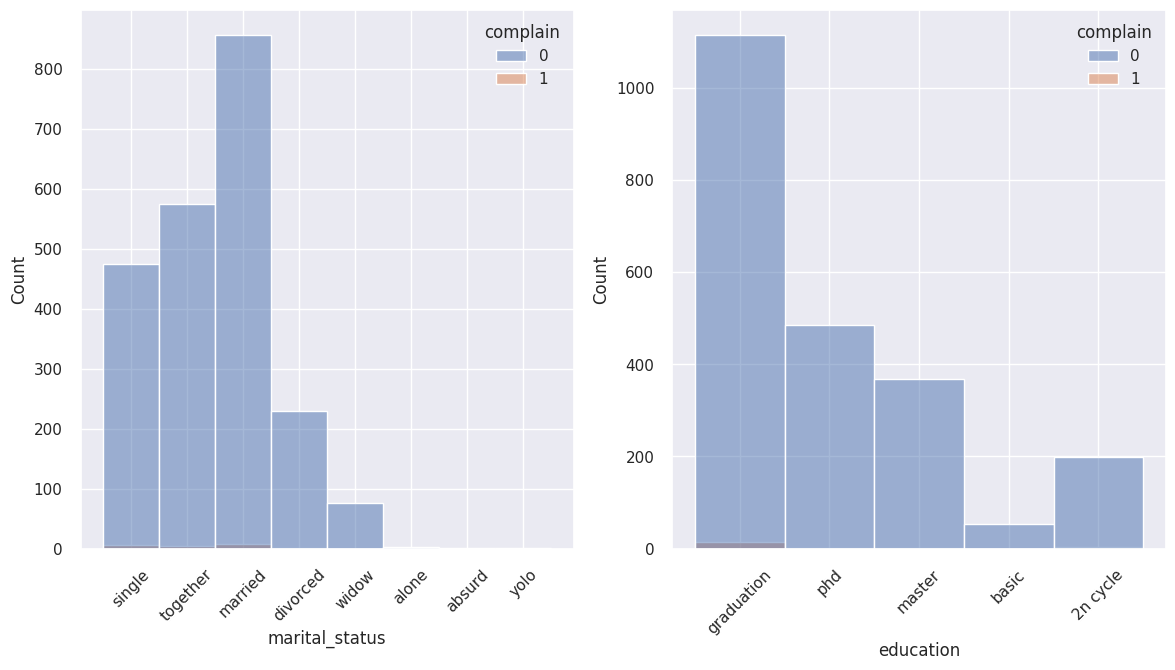

In [9]:
# Object distributions
fig, ax = plt.subplots(1,2)

sns.histplot(data=data, x='marital_status', ax=ax[0], hue='complain')
ax[0].tick_params(axis='x', rotation=45)
sns.histplot(data=data, x='education', ax=ax[1], hue='complain')
ax[1].tick_params(axis='x', rotation=45);

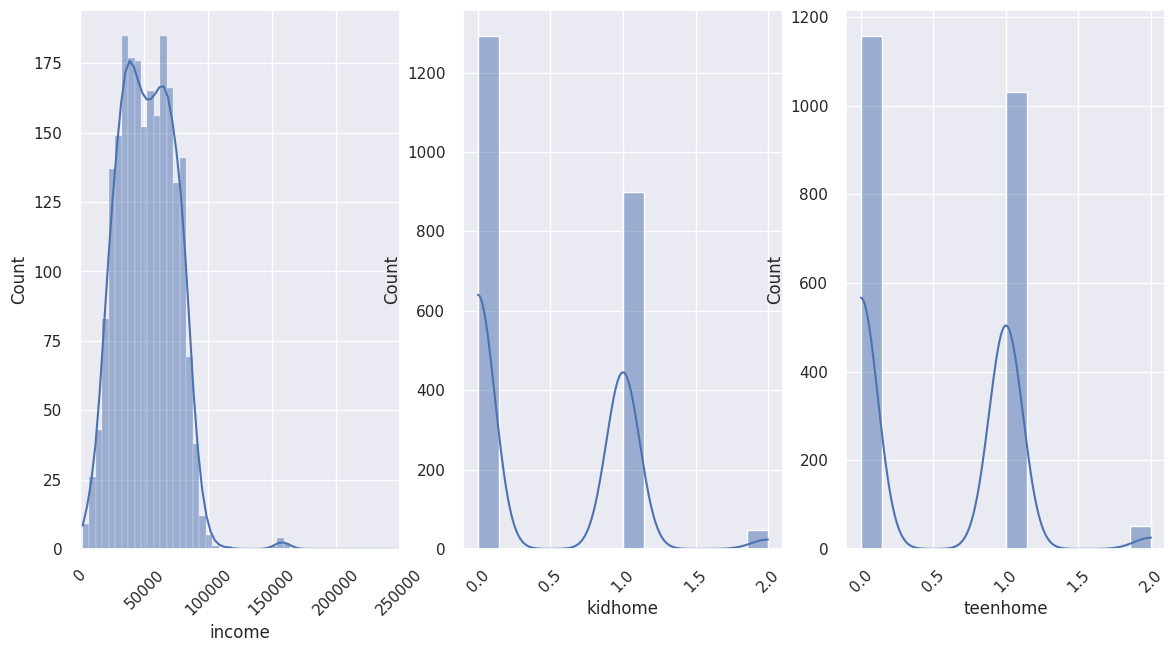

In [10]:
# Object distributions
fig, ax = plt.subplots(1,3)

sns.histplot(data=data, x='income', ax=ax[0], kde=True)
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_xlim(0,250000)

sns.histplot(data=data, x='kidhome', ax=ax[1], kde=True)
ax[1].tick_params(axis='x', rotation=45)

sns.histplot(data=data, x='teenhome', ax=ax[2], kde=True)
ax[2].tick_params(axis='x', rotation=45);

In [11]:
display_all(data.head())

id  year_birth   education marital_status   income  kidhome  teenhome  \
0  5524        1957  graduation         single  58138.0        0         0   
1  2174        1954  graduation         single  46344.0        1         1   
2  4141        1965  graduation       together  71613.0        0         0   
3  6182        1984  graduation       together  26646.0        1         0   
4  5324        1981         phd        married  58293.0        1         0   

  dt_customer  recency  mntwines  mntfruits  mntmeatproducts  mntfishproducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014       94       173         43              118               46   

   mntsweetproducts  mntgoldprods  numdealspurchases  numwebpurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   numcatalogpurchases  numstorepurchases  numwebvisitsmonth  acceptedcmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   acceptedcmp4  acceptedcmp5  acceptedcmp1  acceptedcmp2  complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   z_costcontact  z_revenue  response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0

In [12]:
# Column for customer age
data['age'] = datetime.now().year - data['year_birth']

# Renaming Marital status to create 3 classes
data['marital_status'] = data["marital_status"].replace({
    "married":"cohabit", 
    "together":"cohabit", 
    "absurd": "single",
    "widow":"previous_cohabit", 
    "yolo":"single", 
    "alone": "single",
    "divorced":"previous_cohabit",
})
# Renaming Education classes
data['education'] = data["education"].replace({
    "basic": "other",
    "2n cycle": "other",
    "phd": "post_grad",
    "master": "post_grad",
    "graduation": "grad"
})
# Converting the above to categorical dtypes
cat_cols = ['marital_status', 'education']
data[cat_cols] = data[cat_cols].astype('category')


In [13]:
for col in cat_cols:
    print(data[col].cat.categories)

Index(['cohabit', 'previous_cohabit', 'single'], dtype='object')
Index(['grad', 'other', 'post_grad'], dtype='object')


In [14]:
# Replace strings with their cat codes
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
# One hot encoding our categoricals
data = pd.concat([data, pd.get_dummies(data['marital_status'], 
                                       prefix='mar', 
                                       prefix_sep='_',
                                       dtype='int')], axis=1)
data = pd.concat([data, pd.get_dummies(data['education'], 
                                       prefix='edu',
                                       prefix_sep='_',
                                       dtype='int')], axis=1)

In [15]:
## New cumulative columns
# Family size
data['family'] = data['kidhome'] + data['teenhome']
# Monetary values
mon_cols = ['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']
data['monetary'] = data[mon_cols].sum(axis=1)  
# Product quantities by channel
qty_cols = ['numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases']
data['quantity'] = data[qty_cols].sum(axis=1)  

In [16]:
display_all(data.head())

id  year_birth  education  marital_status   income  kidhome  teenhome  \
0  5524        1957          0               2  58138.0        0         0   
1  2174        1954          0               2  46344.0        1         1   
2  4141        1965          0               0  71613.0        0         0   
3  6182        1984          0               0  26646.0        1         0   
4  5324        1981          2               0  58293.0        1         0   

  dt_customer  recency  mntwines  mntfruits  mntmeatproducts  mntfishproducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014       94       173         43              118               46   

   mntsweetproducts  mntgoldprods  numdealspurchases  numwebpurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   numcatalogpurchases  numstorepurchases  numwebvisitsmonth  acceptedcmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   acceptedcmp4  acceptedcmp5  acceptedcmp1  acceptedcmp2  complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   z_costcontact  z_revenue  response  age  mar_0  mar_1  mar_2  edu_0  edu_1  \
0              3         11         1   66      0      0      1      1      0   
1              3         11         0   69      0      0      1      1      0   
2              3         11         0   58      1      0      0      1      0   
3              3         11         0   39      1      0      0      1      0   
4              3         11         0   42      1      0      0      0      0   

   edu_2  family  monetary  quantity  
0      0       0      1617        25  
1      0       2        27         6  
2      0       0       776        21  
3      0       1        53         8  
4      1       1       422        19

Some important considerations:
* For our first pass, we will be lumping all `monetary values` together. 
    * However, gold being listed next to groceries doesn't make intuitive sense and, as such, needs to be revisited.
* `Product quantities` have a similar problem. Totals can be directionally informative, but purchasing channels play in important part in predicting customer behavious and will be revisited as well.
* Same as above for `campaign acceptance` cols.
* `Recency` is being measured in days.
* `Web visits` can be bucketed.

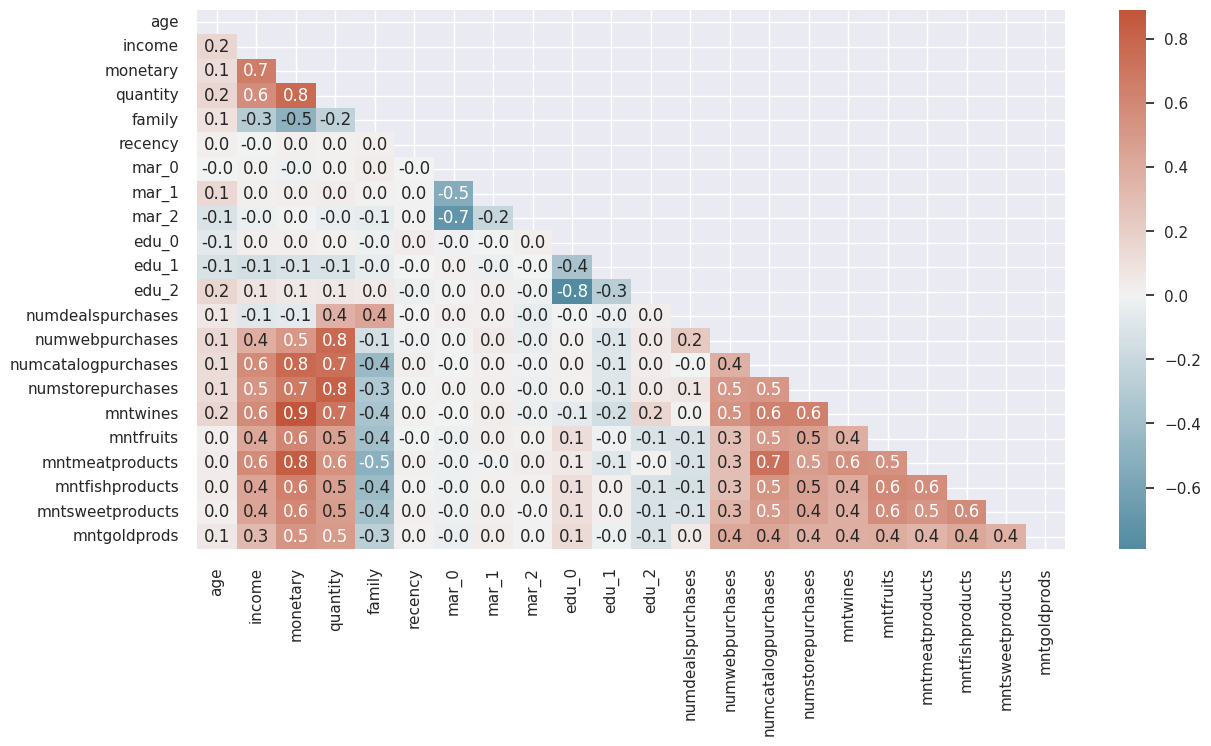

In [17]:
# Let's check correlations between our primary columns 
# Filter cols
cols = ['age', 'income', 'monetary', 'quantity', 'family', 'recency', 
        'mar_0', 'mar_1', 'mar_2', 'edu_0', 'edu_1', 'edu_2',
        'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 
        'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']
cmap = sns.diverging_palette(225, 20, as_cmap=True)
mask = np.triu(data[cols].corr())
sns.heatmap(data[cols].corr(), 
            annot=True,
            fmt='.1f',
            center=0,
            cmap=cmap,
            mask=mask
           )
plt.show()

`Ali's observations`
* **Expense to income ratio** --> expenses were over shooting income. Could be outliers, could be credit based.
* **HYP** Meat and wine have an overlap (hypothesis)
* **HYP** Additional segmentation based on eating habits. ---> vegans or folks who identify as pescatarians might be represented here as well.
* **HYP** Identify customers who spend more and work into products based on spending. Are the ratios of spending the same when compared to lower spending customers. 

* **(HIGH SPEND)** **(LOW SPEND)**

* Frequency x Quantity can be bunched into a "volume" based measure to simplify the model.


**Bilal** (Friday 20th)
* K Means
* OPTICS


**ALI** (Friday 20th)
* Spectral Clustering
* GMM

**Modeling on the assumptions of both RFM and Net Volume**


In [18]:
def rfm_quantile_score(df, r_range=None, fm_range=None):
    """
    Func to create columns for Recency, Frequency and Monetary scores using quantile cuts.
    
    R - will keep nulls and reassign those to category 0.
    
    Club RFM scores for RFM segments.
    
    Sum up RFM for overall score.
    """
    r_labels= r_range
    fm_labels = fm_range
    
    df['R'] = pd.qcut(df['recency'].rank(method='first', na_option='keep'), 3, labels = r_labels)
    df['F'] = pd.qcut(df['quantity'].rank(method='first'), 3, labels = fm_labels)
    df['M'] = pd.qcut(df['monetary'], 3, labels = fm_labels)
    
    df['R'] = df['R'].cat.add_categories('0')
    df['R'].fillna('0', inplace=True)
    
    df['RFM_Segment'] = df['R'].astype(str) + df['F'].astype(str) + df['M'].astype(str)
    df['RFM_score'] = df[['R', 'F', 'M']].apply(pd.to_numeric, errors='coerce').sum(axis=1)
    
    return df

In [19]:
display_all(data.head())

id  year_birth  education  marital_status   income  kidhome  teenhome  \
0  5524        1957          0               2  58138.0        0         0   
1  2174        1954          0               2  46344.0        1         1   
2  4141        1965          0               0  71613.0        0         0   
3  6182        1984          0               0  26646.0        1         0   
4  5324        1981          2               0  58293.0        1         0   

  dt_customer  recency  mntwines  mntfruits  mntmeatproducts  mntfishproducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014       94       173         43              118               46   

   mntsweetproducts  mntgoldprods  numdealspurchases  numwebpurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   numcatalogpurchases  numstorepurchases  numwebvisitsmonth  acceptedcmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   acceptedcmp4  acceptedcmp5  acceptedcmp1  acceptedcmp2  complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   z_costcontact  z_revenue  response  age  mar_0  mar_1  mar_2  edu_0  edu_1  \
0              3         11         1   66      0      0      1      1      0   
1              3         11         0   69      0      0      1      1      0   
2              3         11         0   58      1      0      0      1      0   
3              3         11         0   39      1      0      0      1      0   
4              3         11         0   42      1      0      0      0      0   

   edu_2  family  monetary  quantity  
0      0       0      1617        25  
1      0       2        27         6  
2      0       0       776        21  
3      0       1        53         8  
4      1       1       422        19

In [20]:
rfm_quantile_score(data, r_range=range(3, 0, -1), fm_range=range(1, 4))

id  year_birth  education  marital_status   income  kidhome  \
0      5524        1957          0               2  58138.0        0   
1      2174        1954          0               2  46344.0        1   
2      4141        1965          0               0  71613.0        0   
3      6182        1984          0               0  26646.0        1   
4      5324        1981          2               0  58293.0        1   
...     ...         ...        ...             ...      ...      ...   
2235  10870        1967          0               0  61223.0        0   
2236   4001        1946          2               0  64014.0        2   
2237   7270        1981          0               1  56981.0        0   
2238   8235        1956          2               0  69245.0        0   
2239   9405        1954          2               0  52869.0        1   

      teenhome dt_customer  recency  mntwines  ...  edu_1  edu_2  family  \
0            0  04-09-2012       58       635  ...      0      0       0   
1            1  08-03-2014       38        11  ...      0      0       2   
2            0  21-08-2013       26       426  ...      0      0       0   
3            0  10-02-2014       26        11  ...      0      0       1   
4            0  19-01-2014       94       173  ...      0      1       1   
...        ...         ...      ...       ...  ...    ...    ...     ...   
2235         1  13-06-2013       46       709  ...      0      0       1   
2236         1  10-06-2014       56       406  ...      0      1       3   
2237         0  25-01-2014       91       908  ...      0      0       0   
2238         1  24-01-2014        8       428  ...      0      1       1   
2239         1  15-10-2012       40        84  ...      0      1       2   

      monetary  quantity  R  F  M  RFM_Segment  RFM_score  
0         1617        25  2  3  3          233          8  
1           27         6  2  1  1          211          4  
2          776        21  3  3  2          332          8  
3           53         8  3  1  1          311          5  
4          422        19  1  2  2          122          5  
...        ...       ... .. .. ..          ...        ...  
2235      1341        18  2  2  3          223          7  
2236       444        22  2  3  2          232          7  
2237      1241        19  1  3  3          133          7  
2238       843        23  3  3  3          333          9  
2239       172        11  2  2  2          222          6  

[2240 rows x 44 columns]

Text(0.5, 1.0, 'RFM OVERALL SCORES')

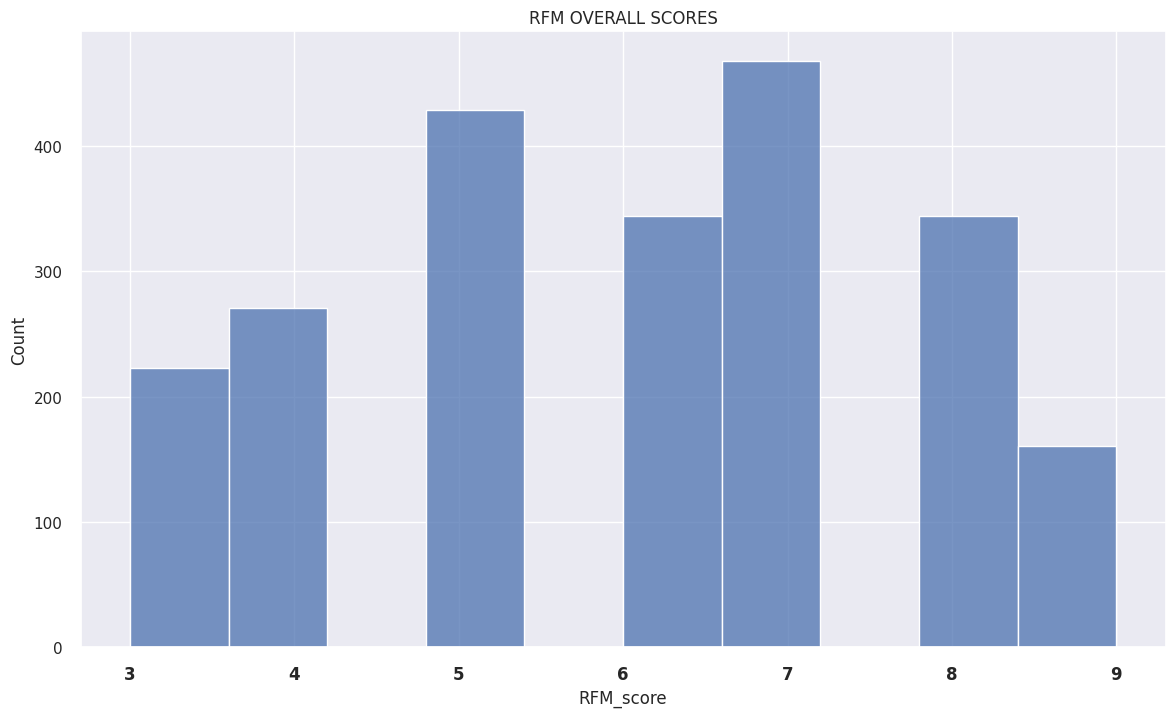

In [21]:
plt.figure(figsize=(14,8))
sns.histplot(data=data, x='RFM_score', bins=10)
plt.xticks(fontweight='bold', fontsize=12)
plt.title('RFM OVERALL SCORES')

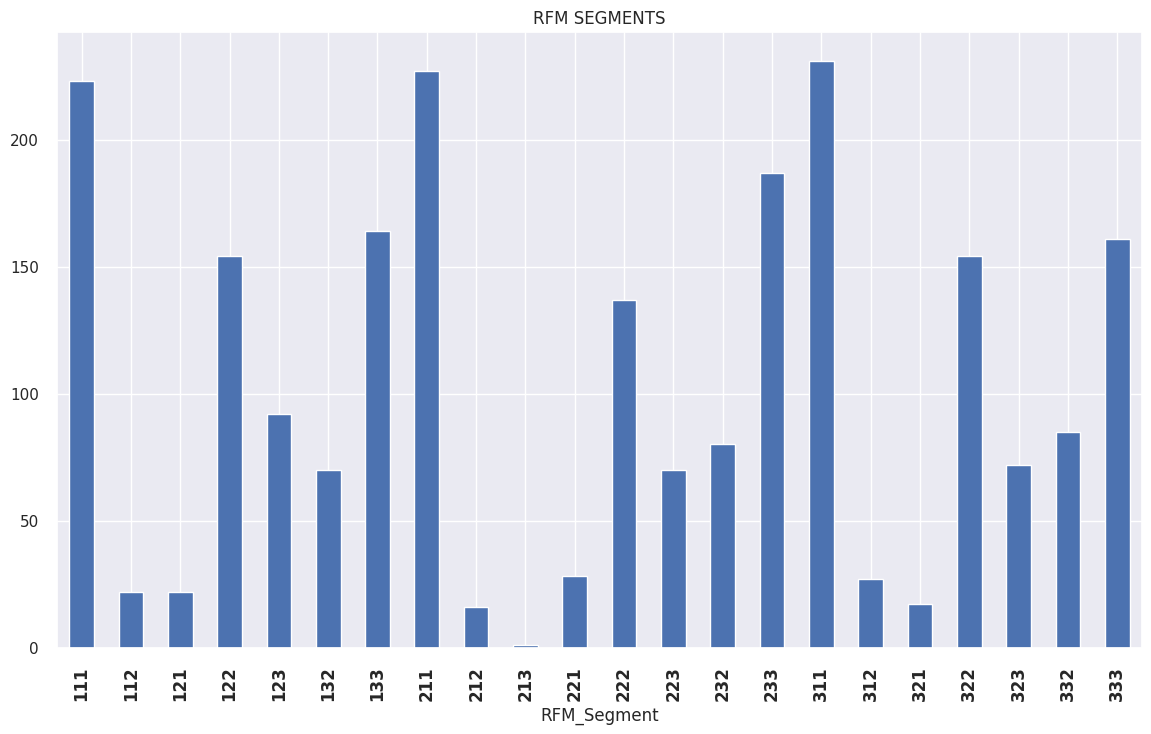

In [22]:
plt.figure(figsize=(14, 8))
data.groupby('RFM_Segment')['id'].count().plot(kind='bar')
plt.xticks(rotation=90, fontweight='bold', fontsize=12)
plt.title('RFM SEGMENTS');